In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 16384/9912422 [00:00<01:11, 138620.28it/s]

9920512it [00:05, 1676979.85it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 305537.36it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 883561.05it/s]                              
8192it [00:00, 175987.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


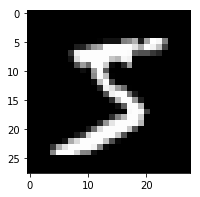

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)        
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)                    
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)        
        x = F.tanh(self.out(x))
        
        return x

In [6]:

# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


# Losses

In [8]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    creterion = nn.BCEWithLogitsLoss()
    if smooth:
        labels = torch.ones(batch_size).to(device)*0.9
    else:
        labels = torch.ones(batch_size).to(device)
        
    loss = creterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)   
    return loss

In [9]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [10]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float().to(device).to(device)

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        real_images = real_images.to(device)
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3812 | g_loss: 0.7077
Epoch [    1/  100] | d_loss: 0.5495 | g_loss: 8.1872
Epoch [    1/  100] | d_loss: 1.0396 | g_loss: 1.2325
Epoch [    2/  100] | d_loss: 1.1557 | g_loss: 1.1427
Epoch [    2/  100] | d_loss: 0.8036 | g_loss: 6.3989
Epoch [    2/  100] | d_loss: 0.5638 | g_loss: 3.1761
Epoch [    3/  100] | d_loss: 0.8047 | g_loss: 1.6718
Epoch [    3/  100] | d_loss: 0.7438 | g_loss: 1.8593
Epoch [    3/  100] | d_loss: 0.7973 | g_loss: 3.1367
Epoch [    4/  100] | d_loss: 0.9816 | g_loss: 1.3926
Epoch [    4/  100] | d_loss: 0.8859 | g_loss: 1.3976
Epoch [    4/  100] | d_loss: 1.1240 | g_loss: 1.3676
Epoch [    5/  100] | d_loss: 0.8684 | g_loss: 2.0941
Epoch [    5/  100] | d_loss: 0.9703 | g_loss: 2.3010
Epoch [    5/  100] | d_loss: 1.1336 | g_loss: 1.6325
Epoch [    6/  100] | d_loss: 1.1073 | g_loss: 1.8069
Epoch [    6/  100] | d_loss: 1.0340 | g_loss: 1.5729
Epoch [    6/  100] | d_loss: 1.1849 | g_loss: 1.2145
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.1206 | g_loss: 1.7174
Epoch [   52/  100] | d_loss: 1.0043 | g_loss: 1.4639
Epoch [   52/  100] | d_loss: 1.0781 | g_loss: 1.7875
Epoch [   52/  100] | d_loss: 1.1165 | g_loss: 1.4364
Epoch [   53/  100] | d_loss: 0.9912 | g_loss: 1.9092
Epoch [   53/  100] | d_loss: 0.9504 | g_loss: 2.3910
Epoch [   53/  100] | d_loss: 0.9869 | g_loss: 1.5835
Epoch [   54/  100] | d_loss: 0.9744 | g_loss: 2.0197
Epoch [   54/  100] | d_loss: 1.0000 | g_loss: 1.3311
Epoch [   54/  100] | d_loss: 1.1522 | g_loss: 1.9575
Epoch [   55/  100] | d_loss: 0.9222 | g_loss: 1.6653
Epoch [   55/  100] | d_loss: 1.1350 | g_loss: 1.1298
Epoch [   55/  100] | d_loss: 1.1574 | g_loss: 1.4449
Epoch [   56/  100] | d_loss: 0.9802 | g_loss: 1.6696
Epoch [   56/  100] | d_loss: 1.0331 | g_loss: 1.6787
Epoch [   56/  100] | d_loss: 1.0716 | g_loss: 1.4903
Epoch [   57/  100] | d_loss: 1.0349 | g_loss: 1.4956
Epoch [   57/  100] | d_loss: 1.0172 | g_loss: 1.9684
Epoch [   57/  100] | d_loss

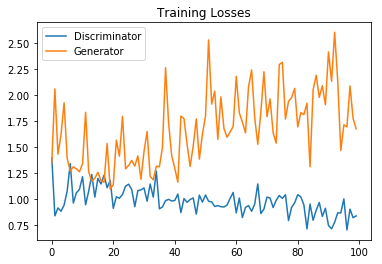

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [12]:

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    samples = samples
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


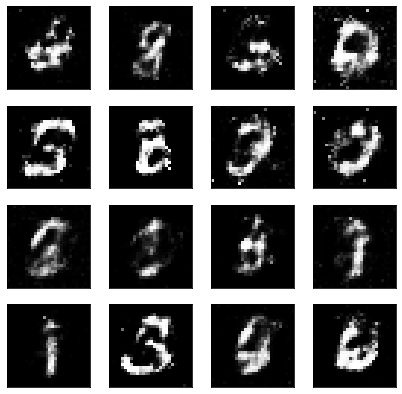

In [13]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float().to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images.to("cpu")])